In [1]:
import time
start_time = time.time()
import progressbar
import os
import numpy as np
from keras.preprocessing import image
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import stats
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import landmarks as l2

Using TensorFlow backend.


In [2]:
# returning feature extraction function within landmark file 
def get_data():
    return l2.extract_features_labels()

def split_data(X, Y):
#   random shuffling of data 
    X, Y = shuffle(X,Y) 
#   split 70% of the dataset as training data and remaning as validation data
    tr_X, te_X, tr_Y, te_Y = train_test_split(X, Y, train_size=0.7)
    
    return tr_X, tr_Y, te_X, te_Y

In [3]:
# reshaping array without changing the data
def reshapeX(X):
    return X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

# mapping similar index of multiple containers of data within feature labels to be used as a single entity
def reshapeY(y):
    return list(zip(*y))[0]

In [4]:
def preprocess():
    import landmarks as l2
    
    # returning landmark features and feature labels as X and Y respectively
    X,y = get_data()
    
    # creating and self transposing array of y, offsetting y values by -1
    Y = np.array([y, -(y - 1)]).T

    tr_X, tr_Y, te_X, te_Y = split_data(X, Y)
    
    tr_X = reshapeX(tr_X)
    te_X = reshapeX(te_X)
    tr_Y = reshapeY(tr_Y)
    te_Y = reshapeY(te_Y)
    
    return tr_X, te_X, tr_Y, te_Y
    
tr_X, te_X, tr_Y, te_Y = preprocess()

In [5]:
# An instance of SVM is created to fit out data.

svc_list = []

# gamma value set as 1/(n_features * X.var())
gamma = 'scale'

# Creating for loop to vary C (regularisation parameter) and polynomial degree
for C in [0.1,1]:
    for degree in [1, 2, 3, 4]:

        lin_svc = svm.SVC(kernel='linear', C=C).fit(tr_X, tr_Y)
        print(C, "Linear:", lin_svc.score(te_X, te_Y))

        rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(tr_X, tr_Y)
        print( C, gamma, "Rbf:", rbf_svc.score(te_X, te_Y))

        poly_svc = svm.SVC(kernel='poly', degree=degree, C=C).fit(tr_X, tr_Y)
        print( C, degree, "Poly", poly_svc.score(te_X, te_Y))

# appending output from all combinations of parameters into a list        
        svc_list.append({
            'lin_svc': lin_svc,
            'rbf_svc': rbf_svc,
            'poly_svc': poly_svc,
            'C': C,
            'gamma': gamma,
            'degree': degree
        })

0.1 Linear: 0.9125
0.1 scale Rbf: 0.49166666666666664
0.1 1 Poly 0.49166666666666664
0.1 Linear: 0.9125
0.1 scale Rbf: 0.49166666666666664
0.1 2 Poly 0.8534722222222222
0.1 Linear: 0.9125
0.1 scale Rbf: 0.49166666666666664
0.1 3 Poly 0.9069444444444444
0.1 Linear: 0.9125
0.1 scale Rbf: 0.49166666666666664
0.1 4 Poly 0.9194444444444444
1 Linear: 0.90625
1 scale Rbf: 0.8458333333333333
1 1 Poly 0.8069444444444445
1 Linear: 0.90625
1 scale Rbf: 0.8458333333333333
1 2 Poly 0.9006944444444445
1 Linear: 0.90625
1 scale Rbf: 0.8458333333333333
1 3 Poly 0.9180555555555555
1 Linear: 0.90625
1 scale Rbf: 0.8458333333333333
1 4 Poly 0.9180555555555555


In [6]:
from sklearn.svm import SVC as svc

In [7]:
# setting upper and lower boundary values for random search range

lin = {'C': stats.uniform(0.1, 10), 'kernel': ['linear']}

rbf = {'C': stats.uniform(0.1, 10), 'gamma': stats.uniform(0.0001, 0.01), 'kernel': ['rbf']}

poly = {'C': stats.uniform(0.1, 10), 'degree': stats.uniform(1, 4), 'kernel': ['poly']}

def randomSearch(X, y, param_kernel):
#   a dictionary with parameters names (string) as keys of parameters to try
    param_distributions = param_kernel 
#   number of jobs = -1 to run all processors; n_iter trades off runtime with quality of solution
#   cv is at default value for 5-fold cross validation
#   verbose gives out messages; refit is to refit an estimator to find the best parameters
#   random_state is a pseudo random number generator used for random uniform sampling from list of possible values instead of using scipy.stats distributions
    searchrand = RandomizedSearchCV(SVC(), param_distributions, n_iter=10, n_jobs=-1, refit=True, verbose=3)
    searchrand.fit(X, y)
    searchrand.cv_results_
#   returns the best parameter values of each kernel along with the kernel 
    return searchrand.best_params_, searchrand.best_estimator_ 
    
    
# Obtaining optimum hyperparameters and classifier for different kernels
linSVC_param, lin_SVC = randomSearch(tr_X, tr_Y, lin)
rbfSVC_param, rbf_SVC = randomSearch(tr_X, tr_Y, rbf)
polySVC_param, poly_SVC = randomSearch(tr_X, tr_Y, poly)

# Display optimum hyperparameters for SVC kernel
print('Optimum hyperparameters for linear kernel: ')
print(linSVC_param)
print('Optimum hyperparameters for rbf kernel: ')
print(rbfSVC_param)
print('Optimum hyperparameters for polynomial kernel: ')
print(polySVC_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.8min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.2s finished


Optimum hyperparameters for linear kernel: 
{'C': 3.91436264876597, 'kernel': 'linear'}
Optimum hyperparameters for rbf kernel: 
{'C': 3.1495794094733376, 'gamma': 0.0007175672036696734, 'kernel': 'rbf'}
Optimum hyperparameters for polynomial kernel: 
{'C': 9.851164840574087, 'degree': 3.132797088972328, 'kernel': 'poly'}


In [8]:
# printing validation accuracy score for each kernel
print(lin_SVC.score(te_X, te_Y))
print(rbf_SVC.score(te_X, te_Y))
print(poly_SVC.score(te_X, te_Y))

0.9041666666666667
0.9083333333333333
0.9236111111111112


In [9]:
# checking on current directory
cwd = os.getcwd()
print(cwd)

C:\Users\82419\Machine Learning\assignment\task A


Automatically created module for IPython interactive environment


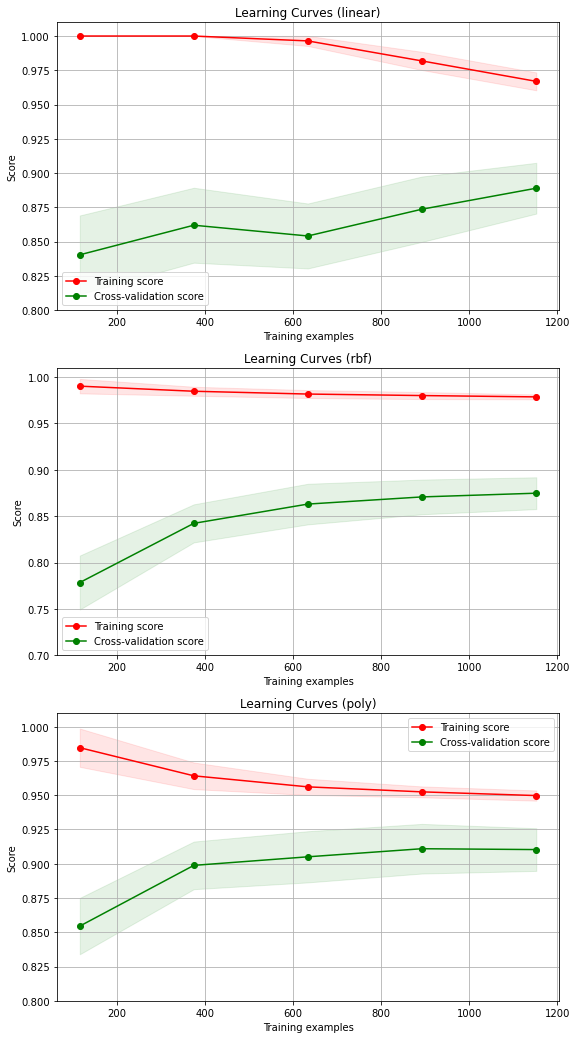

In [10]:
# documentation string to re-write this section into terminal
print(__doc__)



def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plots: the test and training learning curve

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods. Parse linear, rbf and polynomial classifier

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples)
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : Axes to use for plotting the curves.

    ylim : Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
        axes.set_xlabel("Training examples")
        axes.set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
        axes.grid()
        axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        axes.legend(loc="best")

    return plt


plt.figure(figsize=(9,18))

# Cross validation with more iterations to get smoother mean test and train score curves, each time with 20% data randomly selected as a validation set.
# SVC is more expensive so we do a lower number of CV iterations. 
# cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

# plot_learning_curve(estimator, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)
axes = plt.subplot(311)
title = r"Learning Curves (linear)"
plot_learning_curve(lin_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)

axes = plt.subplot(312)
title = r"Learning Curves (rbf)"
plot_learning_curve(rbf_SVC, title, te_X, te_Y, axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

axes = plt.subplot(313)
title = r"Learning Curves (poly)"
plot_learning_curve(poly_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)


plt.show()

In [11]:
# checking validation and training score of chosen classifier
def val_sc(x):
    score = x.score(te_X, te_Y)
    return score

def tr_sc(x):
    score = x.score(tr_X, tr_Y)
    return score

In [12]:
val_sc = val_sc(rbf_SVC)
val_sc

0.9083333333333333

In [13]:
tr_sc = tr_sc(rbf_SVC)
tr_sc

0.9705357142857143